In [1]:
%cd ../..

/home/pristalovya/Документы/nlp-coursework


In [2]:
from datasets_ import DatasetLoader

from datasets import load_dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.utils import resample

import matplotlib.pyplot as plt
%matplotlib notebook

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from transformers import AdamW

from tqdm import tqdm
import numpy as np
import pandas as pd

import sys

from nltk import WhitespaceTokenizer

from transformers import (
    pipeline,                       
    AutoModelForSequenceClassification,                       
    BertForSequenceClassification,                       
    AutoTokenizer,
    AdamW,
)

In [3]:
train, test = DatasetLoader.load_reviews_Review_Label_dataset(train_test_split=True,
                                                              classnames_to_int=True,
                                                              remove_neutral_class=True,
                                                              show_path=True,)
train.label[train['label'] == 2] = 1
test.label[test['label'] == 2] = 1

print(train.label.value_counts())
train = pd.concat([train, resample(train[train.label == 0], n_samples=41608, random_state=42)])
print(train.label.value_counts())

print(train.shape, test.shape)

/home/pristalovya/Документы/nlp-coursework/data/reviews_Review_Label/reviews_Review_Label.csv
1    48477
0     6869
Name: label, dtype: int64
0    48477
1    48477
Name: label, dtype: int64
(96954, 2) (23721, 2)


/tmp/ipykernel_6014/3168397547.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train.label[train['label'] == 2] = 1
/tmp/ipykernel_6014/3168397547.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.label[test['label'] == 2] = 1


In [4]:
test

,review,label
25749,Большое количество фильмов советского кинемато...,1
44489,"Тяжело ответить на вопрос, что же такое Догвил...",1
53162,"В наше время такие героини, как скажем наприме...",0
25843,В 2001 году нам довелось познакомиться с новой...,1
44609,"«Это фильм?», «У них не хватило денег на декор...",1
...,...,...
14104,- Через столько лет?\r\n- Всегда\r\n\r\nБезусл...,1
22232,"После просмотра трейлера, я был под большим вп...",1
73314,"Многие не верят, но я легко подключаюсь к прои...",1
47848,"Как часто нам нужна поддержка? Да, пожалуй, оч...",1


In [9]:
# 

checkpoint = 'blanchefort/rubert-base-cased-sentiment-rusentiment'
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model = AutoModelForSequenceClassification.from_pretrained(checkpoint)

In [4]:
class ReviewDataset(Dataset):
    def __init__(self, reviews, labels, tokenizer, max_model_input_length=512):
        self.reviews = reviews
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_model_input_length = max_model_input_length
        
    def __len__(self):
        return len(self.labels)
        
    def __getitem__(self, idx):
        review = self.reviews.iloc[idx]
        label = self.labels.iloc[idx]
        review_tokenized = self.tokenizer(
            review,
            add_special_tokens=True,
            max_length=self.max_model_input_length,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
            truncation=True,
        )
        input_ids = review_tokenized['input_ids'].flatten()
        attn_mask = review_tokenized['attention_mask'].flatten()
        
        return {
            'review': review,
            'input_ids': input_ids,
            'attention_mask': attn_mask,
            'label': label,
        }
        

In [11]:
model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12

In [5]:
class BertClassifier:
    def __init__(self, checkpoint, n_classes=2):
        
        self.model = BertForSequenceClassification.from_pretrained(checkpoint)
        self.tokenizer = AutoTokenizer.from_pretrained(checkpoint)
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.max_len = 512
        self.out_features = 768
        self.model.classifier = torch.nn.Linear(self.out_features, n_classes)
        self.model.to(self.device)
        self.loss_fn = nn.CrossEntropyLoss()
        
        self.optimizer = torch.optim.Adam(self.model.classifier.parameters(), lr=1e-3)
        self.scheduler = torch.optim.lr_scheduler.StepLR(self.optimizer, step_size=1, gamma=0.5)
        
        self.all_losses = []
        self.epoch_losses = []
        self.epoch_acc = []       
        

    def fit(self):
        self.model.train()
        losses = []
        correct_predictions = 0
        
        t = tqdm(train_dataloader, file=sys.stdout, ncols=100)

        for data in t:
            input_ids = data['input_ids'].to(self.device)
            attention_mask = data['attention_mask'].to(self.device).to(float)
            labels = data['label'].to(self.device)

            outputs = self.model(
                input_ids=input_ids,
                attention_mask=attention_mask
                )

            preds = outputs.logits.argmax(dim=1)
            
            loss = self.loss_fn(outputs.logits, labels)

            correct_predictions += torch.sum(preds == labels)

            losses.append(loss.item())

            loss.backward()
            self.optimizer.step()
            self.optimizer.zero_grad()
            
            t.set_postfix(ordered_dict={'loss': loss.item()}, refresh=True)


        train_acc = correct_predictions.double() / len(train_dataset)
        train_loss = np.mean(losses)
        self.all_losses.extend(losses)
        self.epoch_losses.append(train_loss)
        self.epoch_acc.append(train_acc)
        return train_acc, train_loss
    
    
    def evaluate(self):
        self.model.eval()
        losses = []
        correct_predictions = 0
        
        all_preds = []
        
        t = tqdm(test_dataloader, file=sys.stdout, ncols=100)

        with torch.no_grad():
            for data in t:
                input_ids = data["input_ids"].to(self.device)
                attention_mask = data["attention_mask"].to(self.device)
                labels = data["label"].to(self.device)

                outputs = self.model(
                    input_ids=input_ids,
                    attention_mask=attention_mask
                )

                preds = torch.argmax(outputs.logits, dim=1)
                loss = self.loss_fn(outputs.logits, labels)
                correct_predictions += torch.sum(preds == labels)
                
                all_preds.extend(preds.tolist())
                
                losses.append(loss.item())
                
                t.set_postfix(ordered_dict={'loss': loss.item()}, refresh=True)
                
        print('Classification report:')
        print(classification_report(test_dataset.labels, all_preds))

        val_acc = correct_predictions.double() / len(test_dataset)
        val_loss = np.mean(losses)
        return val_acc.item(), val_loss
    

    
    def train(self, n_epochs, pretrain_test=False):
        try:
            best_accuracy = 0

            if pretrain_test:
                print('Pre-training test:')
                val_acc, val_loss = self.evaluate()
                print(f'Test loss {val_loss} accuracy {val_acc}')
                print('-' * 10)

            for epoch in range(n_epochs):
                print(f'Epoch {epoch + 1}/{n_epochs}')
                train_acc, train_loss = self.fit()
                print(f'Train loss {train_loss} accuracy {train_acc}')

                val_acc, val_loss = self.evaluate()
                print(f'Test loss {val_loss} accuracy {val_acc}')
                print('-' * 10)
                
                self.scheduler.step()
    
        except KeyboardInterrupt:
            print('Training was manually stopped. ')


In [7]:
clf = BertClassifier('blanchefort/rubert-base-cased-sentiment-rusentiment')

train_dataset = ReviewDataset(train.review, train.label, clf.tokenizer)
test_dataset = ReviewDataset(test.review, test.label, clf.tokenizer)

train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [8]:
for param in clf.model.bert.parameters():
    param.requires_grad = False
print('All parameters:', sum(p.numel() for p in clf.model.parameters()))
print('Trainable parameters:', sum(p.numel() for p in clf.model.parameters() if p.requires_grad))

All parameters: 177854978
Trainable parameters: 1538


In [9]:
# batch_size = 16. First
clf.train(3, pretrain_test=True)

Pre-training test:
100%|███████████████████████████████████████████████| 1483/1483 [15:24<00:00,  1.60it/s, loss=0.791]
Classification report:
              precision    recall  f1-score   support

           0       0.11      0.75      0.19      2979
           1       0.80      0.14      0.24     20742

    accuracy                           0.22     23721
   macro avg       0.45      0.45      0.22     23721
weighted avg       0.71      0.22      0.23     23721

Test loss 0.7944383264311407 accuracy 0.21588465916276717
----------
Epoch 1/3
100%|█████████████████████████████████████████████| 6060/6060 [1:05:40<00:00,  1.54it/s, loss=0.599]
Train loss 0.3342541773188798 accuracy 0.8540029292241682
100%|███████████████████████████████████████████████| 1483/1483 [15:21<00:00,  1.61it/s, loss=0.402]
Classification report:
              precision    recall  f1-score   support

           0       0.55      0.85      0.67      2979
           1       0.98      0.90      0.94     20742

    

In [8]:
# batch_size = 32
clf.train(3, pretrain_test=True)

Pre-training test:
100%|█████████████████████████████████████████████████| 742/742 [15:16<00:00,  1.24s/it, loss=0.855]
Classification report:
              precision    recall  f1-score   support

           0       0.14      0.99      0.25      2979
           1       0.99      0.16      0.27     20742

    accuracy                           0.26     23721
   macro avg       0.57      0.58      0.26     23721
weighted avg       0.89      0.26      0.27     23721

Test loss 0.8076277367188281 accuracy 0.2623835420091902
----------
Epoch 1/3
100%|█████████████████████████████████████████████| 3030/3030 [1:05:08<00:00,  1.29s/it, loss=0.662]
Train loss 0.3353850394487381 accuracy 0.8534975349134641
100%|█████████████████████████████████████████████████| 742/742 [16:01<00:00,  1.30s/it, loss=0.556]
Classification report:
              precision    recall  f1-score   support

           0       0.45      0.91      0.60      2979
           1       0.99      0.84      0.91     20742

    a

In [9]:
# batch_size = 16. Again
clf.train(3, pretrain_test=True)

Pre-training test:
100%|███████████████████████████████████████████████| 1483/1483 [15:22<00:00,  1.61it/s, loss=0.631]
Classification report:
              precision    recall  f1-score   support

           0       0.38      0.18      0.25      2979
           1       0.89      0.96      0.92     20742

    accuracy                           0.86     23721
   macro avg       0.63      0.57      0.58     23721
weighted avg       0.83      0.86      0.84     23721

Test loss 0.6347173040811869 accuracy 0.8595337464693731
----------
Epoch 1/3
100%|█████████████████████████████████████████████| 6060/6060 [1:05:58<00:00,  1.53it/s, loss=0.448]
Train loss 0.3331579178577848 accuracy 0.8546939785877838
100%|███████████████████████████████████████████████| 1483/1483 [15:35<00:00,  1.58it/s, loss=0.426]
Classification report:
              precision    recall  f1-score   support

           0       0.53      0.88      0.66      2979
           1       0.98      0.89      0.93     20742

    a

In [9]:
# batch_size = 16. Again with scheduler
clf.train(3, pretrain_test=True)

Pre-training test:
100%|███████████████████████████████████████████████| 1483/1483 [16:00<00:00,  1.54it/s, loss=0.785]
Classification report:
              precision    recall  f1-score   support

           0       0.09      0.61      0.15      2979
           1       0.55      0.07      0.12     20742

    accuracy                           0.14     23721
   macro avg       0.32      0.34      0.14     23721
weighted avg       0.49      0.14      0.13     23721

Test loss 0.7867469559307446 accuracy 0.13658783356519538
----------
Epoch 1/3
100%|█████████████████████████████████████████████| 6060/6060 [1:08:15<00:00,  1.48it/s, loss=0.445]
Train loss 0.3330359753288894 accuracy 0.8543123543123543
100%|███████████████████████████████████████████████| 1483/1483 [15:48<00:00,  1.56it/s, loss=0.388]
Classification report:
              precision    recall  f1-score   support

           0       0.59      0.83      0.69      2979
           1       0.97      0.92      0.94     20742

    

In [21]:
import dill

with open('models/custom_rubert_clf.clf', 'wb') as f:
    dill.dump(clf, f)

---

In [9]:
import dill

with open('models/custom_rubert_clf.clf', 'rb') as f:
    clf = dill.load(f)
    
train_dataset = ReviewDataset(train.review, train.label, clf.tokenizer)
test_dataset = ReviewDataset(test.review, test.label, clf.tokenizer)

train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [10]:
clf.scheduler.get_lr()

[0.000125]

In [11]:
# Continue training

clf.train(3, pretrain_test=True)

Pre-training test:
100%|███████████████████████████████████████████████| 1483/1483 [15:57<00:00,  1.55it/s, loss=0.459]
Classification report:
              precision    recall  f1-score   support

           0       0.52      0.89      0.66      2979
           1       0.98      0.88      0.93     20742

    accuracy                           0.88     23721
   macro avg       0.75      0.89      0.79     23721
weighted avg       0.92      0.88      0.90     23721

Test loss 0.27559260171175565 accuracy 0.8833944606045276
----------
Epoch 1/3
100%|█████████████████████████████████████████████| 6060/6060 [1:05:59<00:00,  1.53it/s, loss=0.212]
Train loss 0.30812663930059464 accuracy 0.8679476865317574
100%|███████████████████████████████████████████████| 1483/1483 [15:20<00:00,  1.61it/s, loss=0.416]
Classification report:
              precision    recall  f1-score   support

           0       0.55      0.86      0.67      2979
           1       0.98      0.90      0.94     20742

   

In [13]:
import dill

with open('models/custom_rubert_clf.clf', 'wb') as f:
    dill.dump(clf, f)

<IPython.core.display.Javascript object>


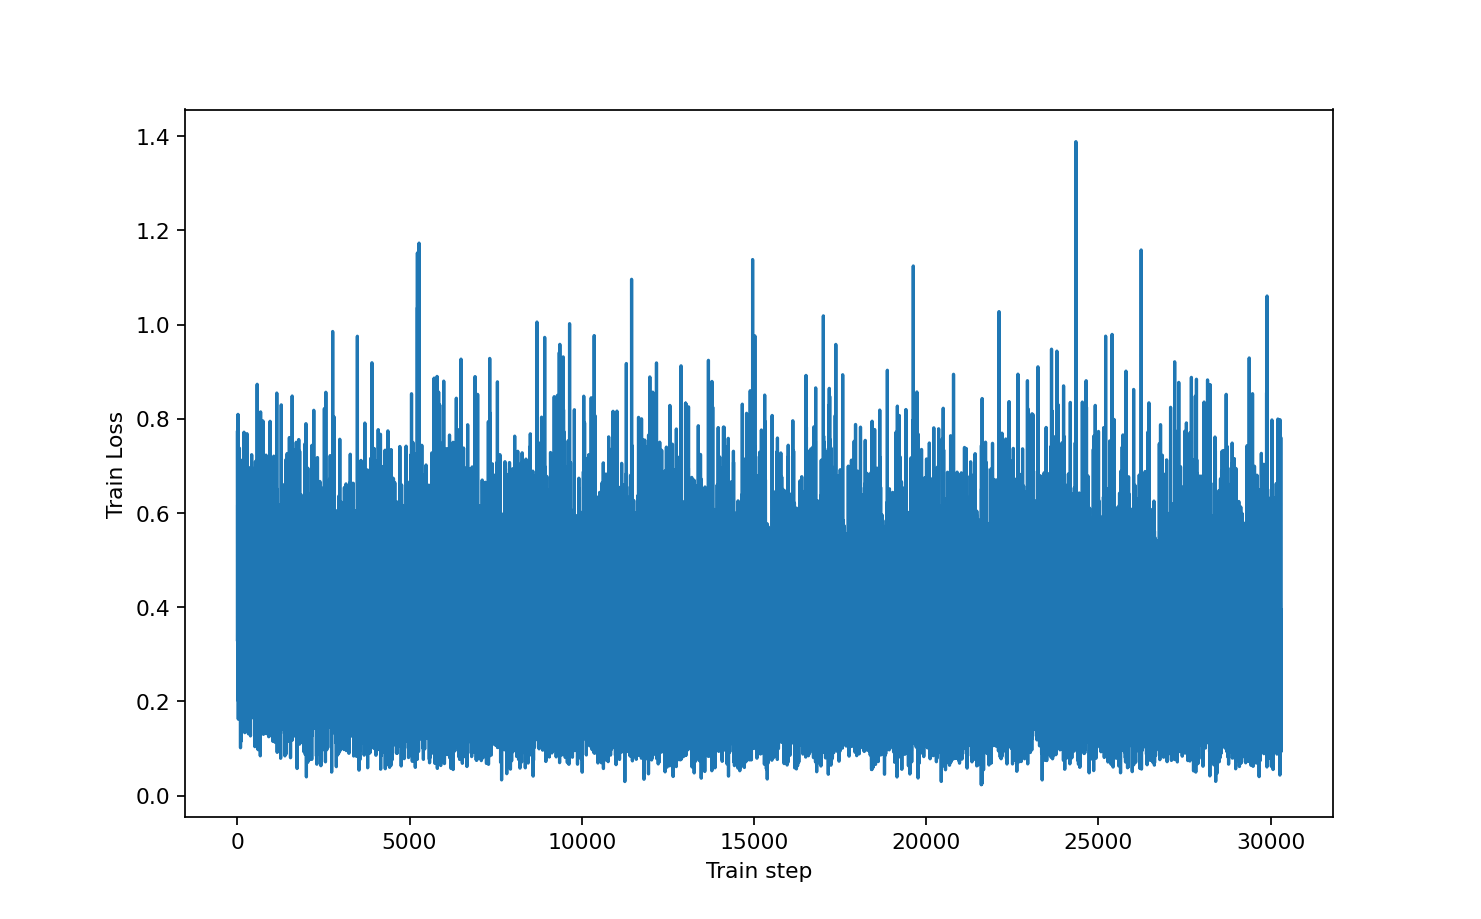

In [14]:
plt.plot(clf.all_losses)
plt.xlabel('Train step')
plt.ylabel('Train Loss')

plt.show()

<IPython.core.display.Javascript object>


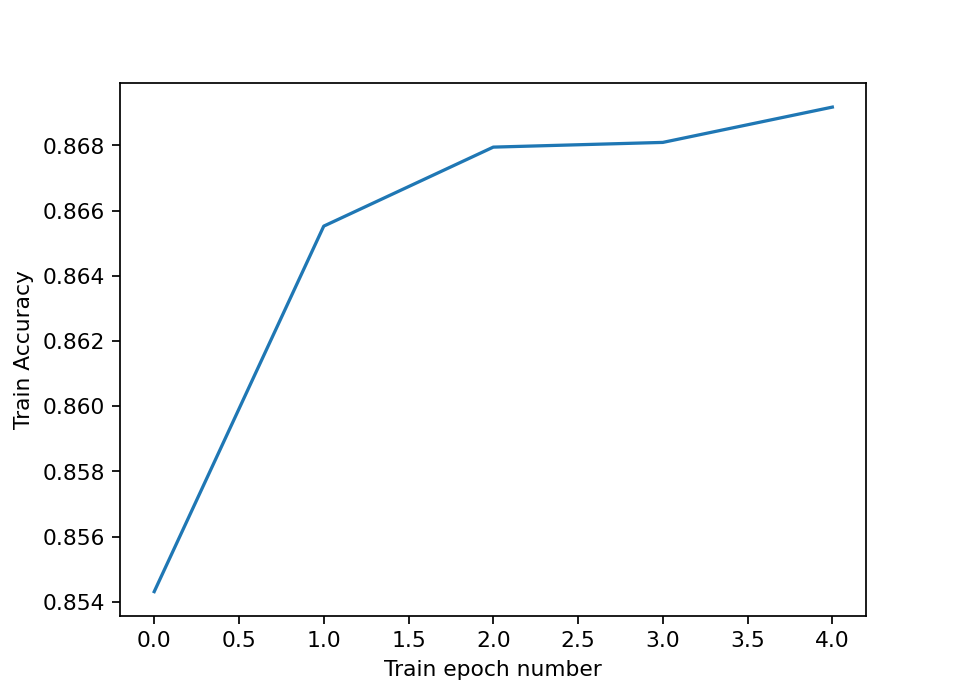

In [15]:
clf.epoch_acc = list(map(lambda t: t.cpu(), clf.epoch_acc))

plt.plot(clf.epoch_acc)
plt.xlabel('Train epoch number')
plt.ylabel('Train Accuracy')

plt.show()

<IPython.core.display.Javascript object>


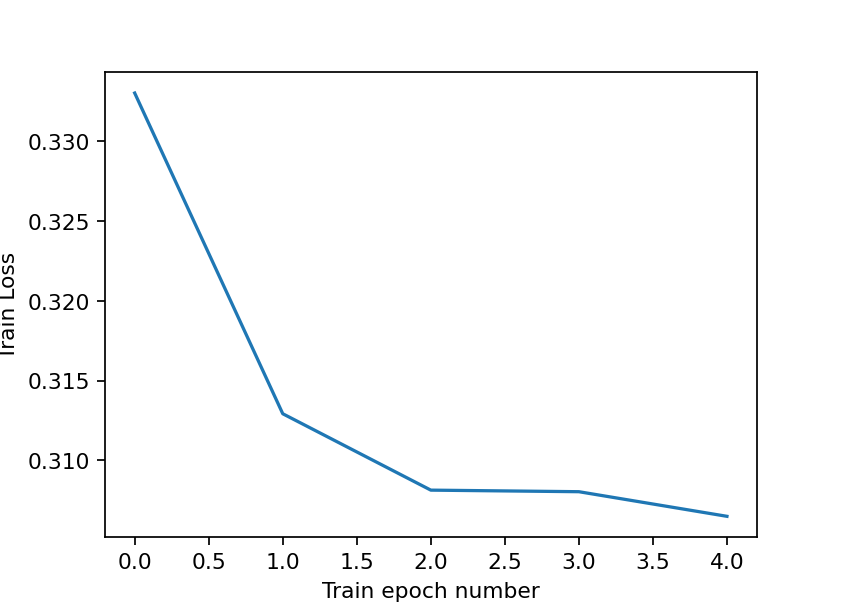

In [16]:
plt.plot(clf.epoch_losses)
plt.xlabel('Train epoch number')
plt.ylabel('Train Loss')

plt.show()

In [20]:
clf.model.save_pretrained('models/rubert_clf')
clf.tokenizer.save_pretrained('models/rubert_clf')

('models/rubert_clf/tokenizer_config.json',
 'models/rubert_clf/special_tokens_map.json',
 'models/rubert_clf/vocab.txt',
 'models/rubert_clf/added_tokens.json',
 'models/rubert_clf/tokenizer.json')